In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from scipy.stats import gaussian_kde

from tqdm.notebook import tqdm

In [2]:
data0  = np.load('pairs_[0.]_mb.npy')
data15 = np.load('pairs_[15.]_mb.npy')
data30 = np.load('pairs_[30.]_mb.npy')
data45 = np.load('pairs_[45.]_mb.npy')
data60 = np.load('pairs_[60.]_mb.npy')
data75 = np.load('pairs_[75.]_mb.npy')
data90 = np.load('pairs_[90.]_mb.npy')

all_data_ls = [data0, data15, data30, data45, data60, data75, data90]

In [3]:
data45.shape

(259200, 2)

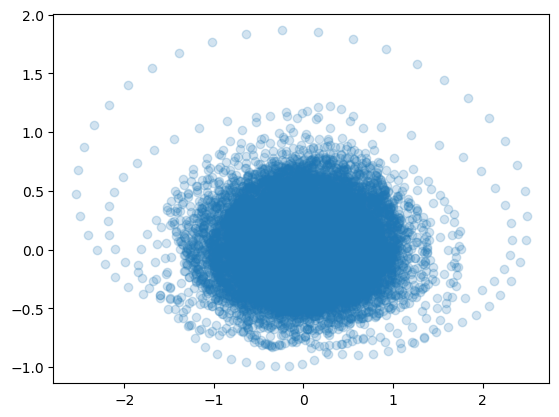

In [4]:
plt.scatter(data45[:,0]*1000, data45[:,1]*1000, alpha = 0.2)

In [5]:
# Define the grid BEFORE the loop
x_min, x_max = -0.4, 0.4
y_min, y_max = -0.4, 0.4
dens = 100

x_grid, y_grid = np.meshgrid(
    np.linspace(x_min, x_max+1/dens, dens), 
    np.linspace(y_min, y_max+1/dens, dens)
)

# Now in your loop, just compute z
xs_ls = []
ys_ls = []
zs_ls = []
x_var = []
y_var = []

for i in tqdm(range(len(all_data_ls))):
    data = all_data_ls[i]
    
    x = data[:,0]*1000
    y = data[:,1]*1000
    query = (np.abs(x)**2 + np.abs(y)**2) > 0.0025
    x = x[query]
    y = y[query]
    print(f'{100*sum(query)/len(query):.2f}%')
    xs_ls.append(x)
    ys_ls.append(y)
    
    kde = gaussian_kde([x, y])
    
    x_var.append(kde.covariance.flatten()[0])
    y_var.append(kde.covariance.flatten()[-1])
    
    # Use the pre-defined x_grid and y_grid
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    
    # Evaluate KDE on the grid
    z = kde(positions).reshape(x_grid.shape)
    zs_ls.append(z)
    

  0%|          | 0/7 [00:00<?, ?it/s]

66.43%
65.18%
62.31%
62.45%
62.27%
65.62%
67.17%


In [6]:
vmax_num = np.ceil(np.array(z).max())

C:\Users\Conai\AppData\Local\Temp\ipykernel_7232\2111237390.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


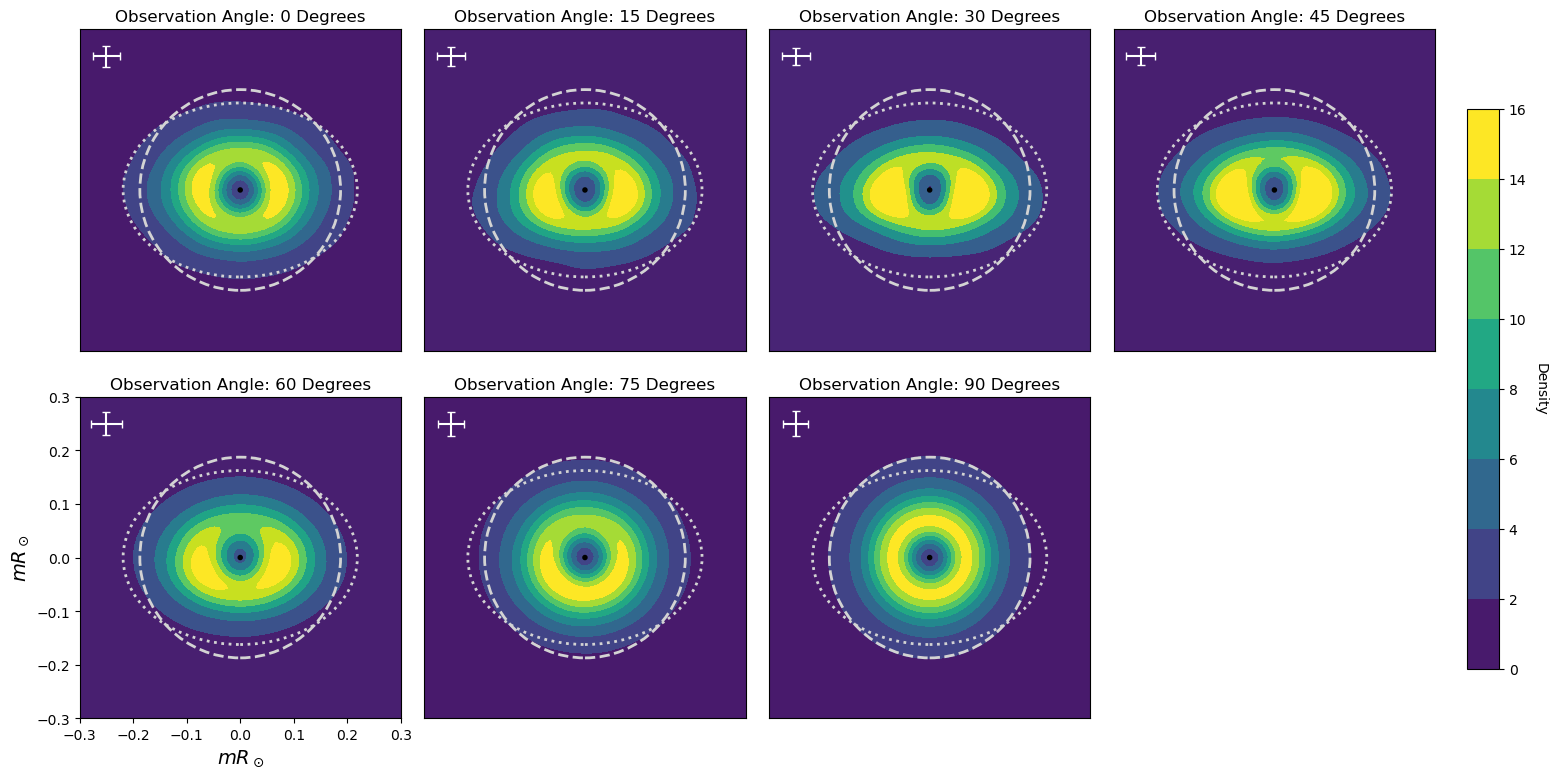

In [12]:

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # Create all subplots at once
axs = axs.ravel()  # Flatten the 2D array of axes for easier iteration
labels = ['0', '15', '30', '45', '60', '75', '90']
radius = 0.0025

# Create a list to store the contour plots
contour_plots = []

for count, z in enumerate(zs_ls, 1):
    if count <= 7:  # Only plot for the first 7 subplots
        ax = axs[count-1]  # Select the current subplot
        contour = ax.contourf(x_grid, y_grid, z, levels=7, cmap="viridis", vmin=0, vmax=vmax_num)
        contour_plots.append(contour)
        
        ax.errorbar(x=-0.25, y=0.25, xerr=np.sqrt(x_var[count-1]), yerr=np.sqrt(y_var[count-1]), capsize=3, color='white')
        if count != 5:
            ax.set_xticks([]); ax.set_yticks([])

        if count == 5:
            ax.set_xlabel(r'$mR_\odot$', fontsize = 14)
            ax.set_ylabel(r'$mR_\odot$', fontsize = 14)
        ax.set_aspect('equal')
        ax.set_xlim([-0.3, 0.3]); ax.set_ylim([-0.3, 0.3])
        ax.set_title('Observation Angle: '+labels[count-1]+' Degrees')
        
        # Add circles and ellipse
        circle1 = patches.Circle((0, 0), radius, color='black', fill=True, linewidth=2)
        circle2 = patches.Circle((0, 0), radius*75, fill=False, linewidth=2, ls='--', color='lightgray')
        ellipse1 = patches.Ellipse((0,0), radius*175, radius*130, linewidth=2, fill=False, ls=':', color='lightgray') 
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(ellipse1)

# Remove the last subplot
fig.delaxes(axs[7])

# Add colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(contour_plots[0], cax=cbar_ax)
cbar.set_label('Density', rotation=270, labelpad=15)

plt.tight_layout()
plt.subplots_adjust(right=0.9)  # Adjust to make room for colorbar
plt.savefig('UnderTheirEyes.pdf')
plt.show()